# 04. Detailed EDA of Merged EUNIS Data

**Goal:** Systematically explore every column in the merged dataset.
**Checks:**
- Missing values (N/As)
- Cardinality (Unique values)
- Distribution (Top occurring values)
- Specific data integrity checks (e.g., Year range, Precision distribution)

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup
processed_dir = Path("../data/processed")
input_file = processed_dir / "eunis_merged_all.parquet"

if not input_file.exists():
    raise FileNotFoundError(f"Merged file not found at {input_file}. Run pipeline first!")

print(f"Loading {input_file}...")
gdf = gpd.read_parquet(input_file)
print(f"Loaded {len(gdf):,} rows.")

Loading ../data/processed/eunis_merged_all.parquet...
Loaded 795,621 rows.


## 1. High-Level Overview
Check missing data percentages across the board.

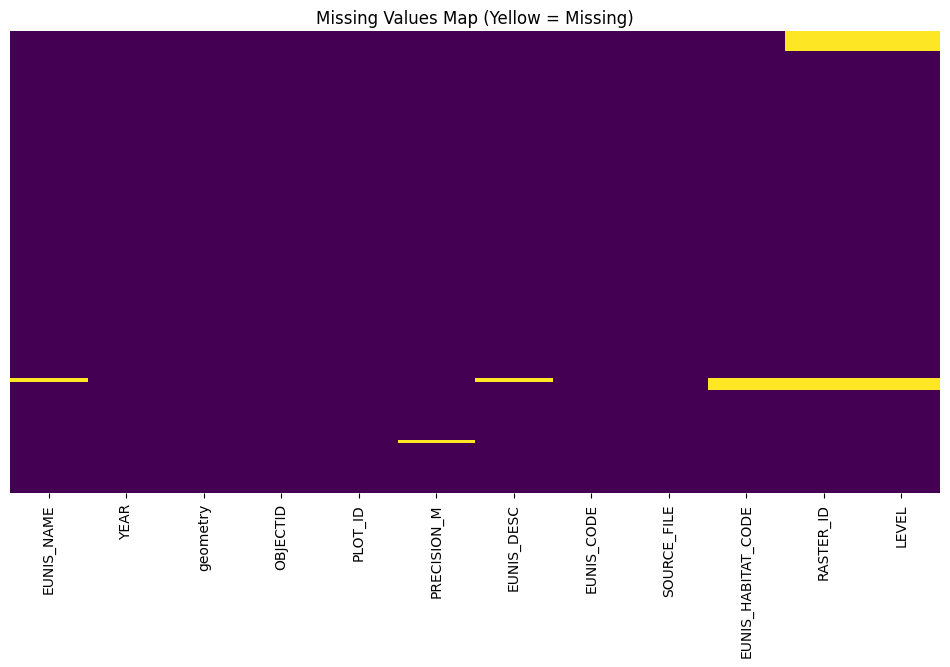

,Missing Values,% Missing,Dtype
EUNIS_NAME,5625,0.71,str
YEAR,0,0.00,str
geometry,0,0.00,geometry
OBJECTID,0,0.00,int32
PLOT_ID,0,0.00,int32
PRECISION_M,5357,0.67,str
EUNIS_DESC,5625,0.71,str
EUNIS_CODE,0,0.00,str
SOURCE_FILE,0,0.00,str
EUNIS_HABITAT_CODE,21141,2.66,str


In [2]:
# Missing Value Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(gdf.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Map (Yellow = Missing)")
plt.show()

# Exact counts
missing_summary = pd.DataFrame({
    'Missing Values': gdf.isnull().sum(),
    '% Missing': (gdf.isnull().sum() / len(gdf) * 100).round(2),
    'Dtype': gdf.dtypes
})
display(missing_summary)

## 2. Column-by-Column Deep Dive

In [3]:
def analyze_column(col_name):
    print(f"\n{'='*40}")
    print(f"🔍 ANALYSIS: {col_name}")
    print(f"{'='*40}")
    
    series = gdf[col_name]
    n_unique = series.nunique()
    n_missing = series.isnull().sum()
    
    print(f"- Unique Values: {n_unique}")
    print(f"- Missing: {n_missing} ({n_missing/len(gdf):.1%})")
    
    # Value Counts (Top 10)
    if n_unique > 0:
        print("\nTOP 10 VALUES:")
        vc = series.value_counts(dropna=False).head(10)
        for val, count in vc.items():
            print(f"  {str(val):<30} : {count:>6} ({count/len(gdf):.1%})")
            
    # Distribution Plot for Numeric columns
    if pd.api.types.is_numeric_dtype(series) and n_unique > 1:
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=series)
        plt.title(f"Distribution of {col_name}")
        plt.show()

### A. EUNIS_CODE (The Primary Key)
We expect high cardinality here. Are there any generic codes like "N/A" or "None"?

In [4]:
analyze_column('EUNIS_CODE')

# Check structure: Do we have Level 1 (A), Level 2 (A1), or Level 3 (A1.1)?
# We can infer level from string length/dots if LEVEL_ORIGINAL is missing.
gdf['Calculated_Level'] = gdf['EUNIS_CODE'].astype(str).apply(lambda x: x.count('.') + 2 if '.' in x else len(x))
print("\n--- Inferred Hierarchy Levels ---")
print(gdf['Calculated_Level'].value_counts().sort_index())


🔍 ANALYSIS: EUNIS_CODE
- Unique Values: 234
- Missing: 0 (0.0%)

TOP 10 VALUES:
  R22                            :  74483 (9.4%)
  R1A                            :  46683 (5.9%)
  R21                            :  37053 (4.7%)
  T17                            :  36301 (4.6%)
  R35                            :  27114 (3.4%)
  Q51                            :  24959 (3.1%)
  V15                            :  24128 (3.0%)
  T1E                            :  18748 (2.4%)
  R55                            :  14373 (1.8%)
  T1B                            :  13997 (1.8%)

--- Inferred Hierarchy Levels ---
Calculated_Level
0      5625
3    774480
5     15516
Name: count, dtype: int64


### B. EUNIS_NAME & DESC
Checking for consistency.

In [5]:
analyze_column('EUNIS_NAME')
# Check if Codes and Names are 1:1 mapped (Ideal) or 1:Many (Inconsistent naming)
code_name_counts = gdf.groupby('EUNIS_CODE')['EUNIS_NAME'].nunique()
inconsistent = code_name_counts[code_name_counts > 1]
if not inconsistent.empty:
    print(f"\n⚠️ Found {len(inconsistent)} codes with multiple names!")
    print(inconsistent.head())
else:
    print("\n✅ Consistency Check: Each EUNIS_CODE maps to exactly one EUNIS_NAME.")


🔍 ANALYSIS: EUNIS_NAME
- Unique Values: 233
- Missing: 5625 (0.7%)

TOP 10 VALUES:
  Low and medium altitude hay meadow :  74483 (9.4%)
  Semi-dry perennial calcareous grassland (meadow steppe) :  46683 (5.9%)
  Mesic permanent pasture of lowlands and mountains :  37053 (4.7%)
  Fagus forest on non-acid soils :  36301 (4.6%)
  Moist or wet mesotrophic to eutrophic hay meadow :  27114 (3.4%)
  Tall-helophyte bed             :  24959 (3.1%)
  Bare tilled, fallow or recently abandoned arable land :  24128 (3.0%)
  Carpinus and Quercus mesic deciduous forest :  18748 (2.4%)
  Lowland moist or wet tall-herb and fern fringe :  14373 (1.8%)
  Acidophilous Quercus forest    :  13997 (1.8%)

✅ Consistency Check: Each EUNIS_CODE maps to exactly one EUNIS_NAME.


### C. YEAR (Temporal Coverage)
Critical for GEE: Are we mapping 1950s data or 2020s data?


🔍 ANALYSIS: YEAR
- Unique Values: 127
- Missing: 0 (0.0%)

TOP 10 VALUES:
                                 : 103397 (13.0%)
  1999                           :  20915 (2.6%)
  1996                           :  20414 (2.6%)
  1998                           :  17509 (2.2%)
  1994                           :  17452 (2.2%)
  1997                           :  17366 (2.2%)
  1995                           :  16484 (2.1%)
  2009                           :  16125 (2.0%)
  2001                           :  16064 (2.0%)
  2000                           :  15839 (2.0%)

Valid Years Range: 1901 - 2020


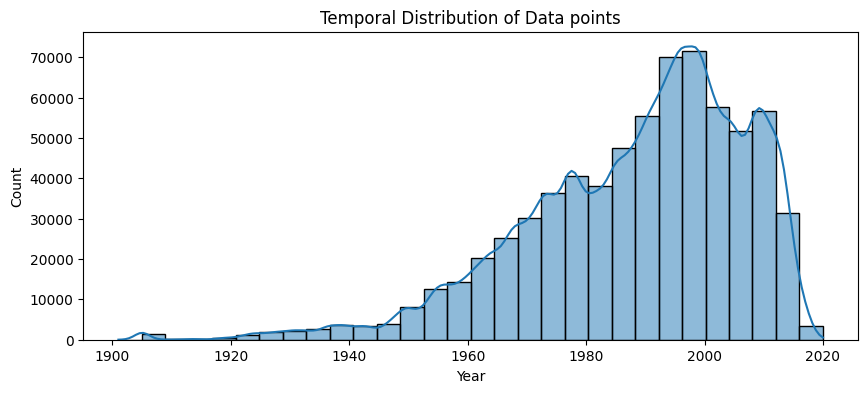

In [6]:
analyze_column('YEAR')

# Convert to numeric first, coercing errors to NaN
# This handles strings like "2010", "unknown", or "0" safely
year_numeric = pd.to_numeric(gdf['YEAR'], errors='coerce')

# Filter for valid range (e.g., 1900 to present)
valid_years = year_numeric[(year_numeric > 1900) & (year_numeric < 2025)]

if not valid_years.empty:
    print(f"\nValid Years Range: {int(valid_years.min())} - {int(valid_years.max())}")
    plt.figure(figsize=(10, 4))
    sns.histplot(valid_years, bins=30, kde=True)
    plt.title("Temporal Distribution of Data points")
    plt.xlabel("Year")
    plt.show()
else:
    print("No valid year data found (all N/A or out of range).")

### D. PRECISION_M (Spatial Accuracy)
If precision is > 10,000m, the point is useless for training a 10m Sentinel-2 classifier.

In [7]:
analyze_column('PRECISION_M')


🔍 ANALYSIS: PRECISION_M
- Unique Values: 341
- Missing: 5357 (0.7%)

TOP 10 VALUES:
                                 : 655007 (82.3%)
  0                              :  18821 (2.4%)
  10000                          :  14885 (1.9%)
  1000                           :  13978 (1.8%)
  5000                           :  12003 (1.5%)
  100                            :  11842 (1.5%)
  10                             :   6128 (0.8%)
  3                              :   5819 (0.7%)
  nan                            :   5357 (0.7%)
  2000                           :   5190 (0.7%)


### E. SOURCE_FILE
Which datasets contributed the most points?

In [8]:
analyze_column('SOURCE_FILE')


🔍 ANALYSIS: SOURCE_FILE
- Unique Values: 8
- Missing: 0 (0.0%)

TOP 10 VALUES:
  EUNIS_Grassland_Distribution_point.geojson : 298801 (37.6%)
  EUNIS_Forest_Distribution_point.geojson : 220601 (27.7%)
  EUNIS_Wetlands_Distribution_point.geojson :  92468 (11.6%)
  EUNIS_Vegetated_Distribution_point.geojson :  79069 (9.9%)
  EUNIS_Hethland_Distribution_point.geojson :  42918 (5.4%)
  EUNIS_Coastal_Distribution_point.geojson :  34102 (4.3%)
  EUNIS_Saltmarshes_Distribution_point.geojson :  21141 (2.7%)
  EUNIS_Sparsely_Distribution_point.geojson :   6521 (0.8%)


### F. RASTER_FILE & METADATA
Checking the technical fields.


🔍 ANALYSIS: PLOT_ID
- Unique Values: 224532
- Missing: 0 (0.0%)

TOP 10 VALUES:
  0                              : 562320 (70.7%)
  514027                         :      3 (0.0%)
  798844                         :      3 (0.0%)
  798852                         :      3 (0.0%)
  798858                         :      3 (0.0%)
  922663                         :      3 (0.0%)
  924062                         :      3 (0.0%)
  924071                         :      3 (0.0%)
  924078                         :      3 (0.0%)
  924083                         :      3 (0.0%)


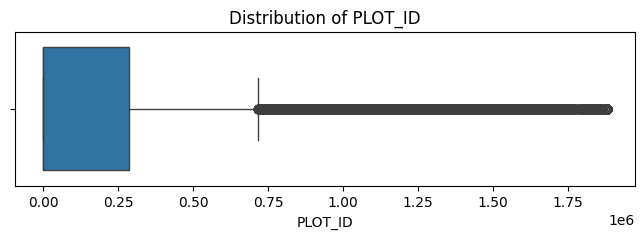

In [9]:
for col in ['RASTER_FILE', 'LEVEL_ORIGINAL', 'PLOT_ID']:
    if col in gdf.columns:
        analyze_column(col)

## 3. Geometry Check
Ensure everything is a Point and check for duplicates (same location, same code).

In [10]:
print(f"\nGeometry Types: {gdf.geom_type.unique()}")

# Check for Duplicate Geometries (Stacking)
# Same exact point, same exact code = Redundant
duplicates = gdf.duplicated(subset=['EUNIS_CODE', 'geometry']).sum()
print(f"Exact Duplicates (Code + Location): {duplicates} ({duplicates/len(gdf):.1%})")

# Check for Location Conflicts
# Same location, DIFFERENT code = Confusion for Classifier
loc_conflicts = gdf.duplicated(subset=['geometry'], keep=False)
conflict_gdf = gdf[loc_conflicts]
if not conflict_gdf.empty:
    n_conflicts = conflict_gdf.groupby(conflict_gdf.geometry.to_wkt())['EUNIS_CODE'].nunique()
    real_conflicts = n_conflicts[n_conflicts > 1]
    print(f"Spatial Conflicts (Same Point, Different Class): {len(real_conflicts)} locations")


Geometry Types: <ArrowStringArray>
['Point']
Length: 1, dtype: str
Exact Duplicates (Code + Location): 292485 (36.8%)
Spatial Conflicts (Same Point, Different Class): 40417 locations
